# Motivational Qualities of Songs for Daily Activities

In this assignment you will work on a study on song features and how they can be used as the basis for recommendations for specific daily activities. The study is:

* Kim, Y., Aiello, L.M. & Quercia, D. PepMusic: motivational qualities of songs for daily activities. EPJ Data Sci. 9, 13 (2020). https://doi.org/10.1140/epjds/s13688-020-0221-9

You can download the study from the above link. You can use the dataset provided by the authors, which is available inside the present folder at [data_archive_20190201.json](./data_archive_20190201.json).

---

> Panos Louridas, Associate Professor <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> louridas@aueb.gr

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import classification_report, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf

In [3]:
json_data = pd.read_json('./data_archive_20190201.json').transpose()
json_data.head()

,trackId,artists,songTitle,features,activityType,clusteringLabel,youtubeId,youtubeURL,spotifyTrackURL
0,3Vo4wInECJQuz9BIBMOu8i,"[Bruno Mars, Cardi B]",Finesse (Remix) [feat. Cardi B],"{'chordsScale': 'minor', 'chordsKey': 'F', 'bp...",exercising,intense,GIfa9Y4vxi8,https://www.youtube.com/watch?v=GIfa9Y4vxi8,https://open.spotify.com/track/3Vo4wInECJQuz9B...
1,7ef4DlsgrMEH11cDZd32M6,"[Calvin Harris, Dua Lipa]",One Kiss (with Dua Lipa),"{'chordsScale': 'minor', 'chordsKey': 'A', 'bp...",exercising,intense,XWCPbRsMb0Q,https://www.youtube.com/watch?v=XWCPbRsMb0Q,https://open.spotify.com/track/7ef4DlsgrMEH11c...
2,3Nou5g8qSke2RT562MoAtn,[Monique Namaste],Water Harp,"{'chordsScale': 'minor', 'chordsKey': 'F', 'bp...",relaxing,calm,LMz_ggmEKws,https://www.youtube.com/watch?v=LMz_ggmEKws,https://open.spotify.com/track/3Nou5g8qSke2RT5...
3,5wfHmgTmRjXVdVTn7YVKtx,"[Cameron, Yoga Music, Spa, Massage]",Epic Dream,"{'chordsScale': 'major', 'chordsKey': 'G', 'bp...",relaxing,calm,LSLmVdtd8_0,https://www.youtube.com/watch?v=LSLmVdtd8_0,https://open.spotify.com/track/5wfHmgTmRjXVdVT...
4,4oIZXnjmEjq2FWMBl1D8ef,"[Cameron, Yoga Music, Meditation Spa]",Tantric Sleep,"{'chordsScale': 'major', 'chordsKey': 'D', 'bp...",relaxing,calm,Snib7unaL_4,https://www.youtube.com/watch?v=Snib7unaL_4,https://open.spotify.com/track/4oIZXnjmEjq2FWM...


In [4]:
# Extract every information from features into separate columns
features_df = pd.json_normalize(json_data['features'])

# Keep important infromation in separate dataframe
df = pd.concat([json_data[['trackId', 'artists', 'songTitle']], features_df], axis=1)
df.head()

,trackId,artists,songTitle,chordsScale,chordsKey,bpm,rhythmHist,regularity,rhythmPattern,keyKey,loudness,pitchBiHist,keyScale
0,3Vo4wInECJQuz9BIBMOu8i,"[Bruno Mars, Cardi B]",Finesse (Remix) [feat. Cardi B],minor,F,104.992523,"[16.8285816268, 13.671369549, 12.3919854605, 1...",1.254250,"[0.044795403000000004, 0.052395507800000005, 0...",F,-9.026863,"[[0.0, 0.1277345147, 0.14194756320000002, 0.10...",minor
1,7ef4DlsgrMEH11cDZd32M6,"[Calvin Harris, Dua Lipa]",One Kiss (with Dua Lipa),minor,A,123.547798,"[21.1346154077, 18.6496586356, 16.3906795752, ...",1.325307,"[0.0177695819, 0.027610449300000003, 0.0229472...",A,-6.811761,"[[0.0, 0.11182582760000001, 0.0811748826, 0.03...",minor
2,3Nou5g8qSke2RT562MoAtn,[Monique Namaste],Water Harp,minor,F,103.211197,"[10.1532813965, 5.9777501213, 6.4212765238, 4....",0.948574,"[0.0185314204, 0.0444592176, 0.034440893800000...",F,-11.597279,"[[0.0, 0.014519404100000001, 0.0005754217, 0.0...",minor
3,5wfHmgTmRjXVdVTn7YVKtx,"[Cameron, Yoga Music, Spa, Massage]",Epic Dream,major,G,116.554108,"[20.8648159848, 14.171234524599999, 10.3256045...",1.012330,"[0.0142917145, 0.0385265817, 0.0566188779, 0.0...",G,-11.627250,"[[0.0, 0.0575464752, 0.016889968800000002, 0.0...",major
4,4oIZXnjmEjq2FWMBl1D8ef,"[Cameron, Yoga Music, Meditation Spa]",Tantric Sleep,major,D,154.680176,"[10.6034373863, 5.3603348431, 4.4752242598, 3....",1.076835,"[0.0137198961, 0.031543038600000003, 0.0306120...",D,-12.274364,"[[0.0, 0.0161060935, 0.0092525277, 0.000938512...",major


## Questions

### Q1: Clustering 

You will perform a clustering on the songs, using KMeans. The authors identify the optimum number of clusters by using the elbow method (gives four clusters) and the silhouette score (gives two) clusters and taking their average, i.e., three clusters.

Use both methods, like the authors, check the results, and then use three clusters. Visualize the clusters by using PCA on two dimensions.

Note that the data given by the authors contain the results of their clustering. Of course this will not be a feature that you will use for your clustering. The features you will use for clustering will be:

* `chordsScale`

* `chordsKey`

* `bpm`

* `rhythmHist`

* `regularity`

* `rhythmPattern`

* `keyKey`

* `loudness`

* `pitchBiHist`

* `keyScale`

Not all of these features are atomic, and not all of these features are numerical, so you should make the necessary transformations in the data so that you get all features in a single two-dimensional matrix.

Once you finish your clustering, compare the clusters that you have found with the clusters that the authors have found; how similar are your clusters to theirs? The authors assign activities, given by `activityType`, to clusters as in Table 2. Interpret your clusters like the authors do in the text of the paper and in figures 5, 6, as best as you can. 

We can see that some columns have categorical values. We will need to get the data in the correct format, since clustering algorithms like KMeans expect a flat, numerical matrix where each feature corresponds to a single numeric value.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1107 entries, 0 to 1106
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   trackId        1107 non-null   object 
 1   artists        1107 non-null   object 
 2   songTitle      1107 non-null   object 
 3   chordsScale    1107 non-null   object 
 4   chordsKey      1107 non-null   object 
 5   bpm            1107 non-null   float64
 6   rhythmHist     1107 non-null   object 
 7   regularity     1107 non-null   float64
 8   rhythmPattern  1107 non-null   object 
 9   keyKey         1107 non-null   object 
 10  loudness       1107 non-null   float64
 11  pitchBiHist    1107 non-null   object 
 12  keyScale       1107 non-null   object 
dtypes: float64(3), object(10)
memory usage: 153.4+ KB


In [6]:
# Method that gets the categorical columns and returns a dataframe with a each columns expaned into multiple ones
def encode_categorical_values(df, columns_list):
  encoder = OneHotEncoder()
  categorical_encoded = encoder.fit_transform(df[columns_list]).toarray()
  df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(columns_list))
  return df

# Use the method for our categorical data
categorical_columns = ['chordsScale', 'chordsKey', 'keyKey', 'keyScale']
categorical_df = encode_categorical_values(df, categorical_columns)
categorical_df

,chordsScale_major,chordsScale_minor,chordsKey_A,chordsKey_A#,chordsKey_B,chordsKey_C,chordsKey_C#,chordsKey_D,chordsKey_D#,chordsKey_E,...,keyKey_C#,keyKey_D,keyKey_D#,keyKey_E,keyKey_F,keyKey_F#,keyKey_G,keyKey_G#,keyScale_major,keyScale_minor
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1103,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1104,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1105,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
# Expand columns that hold list values, into multiple columns
def expand_list_columns(df, columns_list):
  expanded_df = []
  for column in columns_list:
    expanded = pd.DataFrame(
      df[column].tolist(),
      columns=[f"{column}_{i+1}" for i in range(len(df[column].iloc[0]))]
    )
    expanded_df.append(expanded)

  expanded_df = pd.concat(expanded_df, axis=1)
  return expanded_df

list_columns = ['rhythmHist', 'rhythmPattern']
lists_df = expand_list_columns(df, list_columns)
lists_df

,rhythmHist_1,rhythmHist_2,rhythmHist_3,rhythmHist_4,rhythmHist_5,rhythmHist_6,rhythmHist_7,rhythmHist_8,rhythmHist_9,rhythmHist_10,...,rhythmPattern_1431,rhythmPattern_1432,rhythmPattern_1433,rhythmPattern_1434,rhythmPattern_1435,rhythmPattern_1436,rhythmPattern_1437,rhythmPattern_1438,rhythmPattern_1439,rhythmPattern_1440
0,16.828582,13.671370,12.391985,10.626953,13.936256,9.275521,9.292874,9.760065,7.866954,10.814794,...,0.072776,0.069650,0.066149,0.056104,0.039921,0.032044,0.024124,0.020591,0.010716,0.002512
1,21.134615,18.649659,16.390680,11.705696,10.676802,12.449783,9.635008,9.073800,9.280776,8.048273,...,0.069902,0.081618,0.068873,0.060022,0.040540,0.030512,0.024943,0.025685,0.016308,0.003539
2,10.153281,5.977750,6.421277,4.704218,3.750520,2.884836,2.895001,3.247822,3.316113,2.755584,...,0.004031,0.004363,0.004479,0.007285,0.007659,0.005314,0.003308,0.001764,0.000635,0.000001
3,20.864816,14.171235,10.325605,8.621210,6.084831,6.555567,6.232464,4.942150,5.290747,4.519774,...,0.022320,0.031757,0.041030,0.015894,0.006924,0.005808,0.004448,0.002412,0.001635,0.000198
4,10.603437,5.360335,4.475224,3.257971,3.282138,3.278527,3.359346,3.076381,2.492136,2.714590,...,0.011398,0.010312,0.008256,0.008059,0.005057,0.004598,0.003742,0.002686,0.001193,0.000076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,18.361203,16.515834,13.847226,10.230485,10.618058,9.822338,7.678320,7.421529,6.454561,6.850138,...,0.027671,0.019581,0.019875,0.010482,0.008682,0.008261,0.009052,0.007369,0.005348,0.000890
1103,11.860368,10.362976,9.353918,7.312323,6.312862,6.109997,5.938760,5.746587,6.024595,5.643823,...,0.051745,0.036448,0.019823,0.020299,0.018910,0.013525,0.009194,0.006866,0.002592,0.000540
1104,23.191069,19.595315,18.912232,14.032734,13.003800,9.991628,9.856728,8.480884,8.005483,7.852465,...,0.035238,0.033615,0.030962,0.022601,0.013489,0.011133,0.009625,0.008066,0.004730,0.000777
1105,15.878196,16.024921,12.748835,15.826062,9.310661,11.133789,9.866823,9.831409,9.534972,8.186435,...,0.042750,0.047690,0.045676,0.037583,0.023433,0.023174,0.022975,0.016582,0.009261,0.002157


The `pitchBiHist` is different because it contains **nested lists**, while other columns like `rhythmHist` have flat lists. Instead of expanding it into many columns (which will increase complexity by a lot), we calculate summary statistics like **mean, standard deviation** to capture its overall behavior in a simpler way.

In [8]:
def encode_pitchBiHist_sublists(df, column):
    # Create a DataFrame with columns for each sublist's mean and standard deviation
    means = df[column].apply(lambda x: [np.mean(sublist) for sublist in x])
    stds = df[column].apply(lambda x: [np.std(sublist) for sublist in x])
    
    # Combine means and stds into a single DataFrame with appropriate column names
    mean_df = pd.DataFrame(means.tolist(), columns=[f'{column}_{i+1}_mean' for i in range(len(means.iloc[0]))])
    std_df = pd.DataFrame(stds.tolist(), columns=[f'{column}_{i+1}_std' for i in range(len(stds.iloc[0]))])
    
    # Combine both DataFrames into one
    return pd.concat([mean_df, std_df], axis=1)

pitchBiHist_df = encode_pitchBiHist_sublists(df, 'pitchBiHist')


In [9]:
numerical_columns = ['bpm', 'regularity', 'loudness']

We will now combine all columns into a **flat, numerical matrix** where each feature corresponds to a single numeric value.


In [10]:
processed_df = pd.concat([
    df[numerical_columns], 
    categorical_df, 
    lists_df,
    pitchBiHist_df,  
  ], axis=1)
processed_df

,bpm,regularity,loudness,chordsScale_major,chordsScale_minor,chordsKey_A,chordsKey_A#,chordsKey_B,chordsKey_C,chordsKey_C#,...,rhythmPattern_1433,rhythmPattern_1434,rhythmPattern_1435,rhythmPattern_1436,rhythmPattern_1437,rhythmPattern_1438,rhythmPattern_1439,rhythmPattern_1440,pitchBiHist_1_mean,pitchBiHist_1_std
0,104.992523,1.254250,-9.026863,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.066149,0.056104,0.039921,0.032044,0.024124,0.020591,0.010716,0.002512,0.031840,0.036931
1,123.547798,1.325307,-6.811761,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.068873,0.060022,0.040540,0.030512,0.024943,0.025685,0.016308,0.003539,0.014878,0.033507
2,103.211197,0.948574,-11.597279,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.004479,0.007285,0.007659,0.005314,0.003308,0.001764,0.000635,0.000001,0.001507,0.022597
3,116.554108,1.012330,-11.627250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.041030,0.015894,0.006924,0.005808,0.004448,0.002412,0.001635,0.000198,0.004400,0.024098
4,154.680176,1.076835,-12.274364,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008256,0.008059,0.005057,0.004598,0.003742,0.002686,0.001193,0.000076,0.001929,0.024166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,123.126984,0.957697,-13.066373,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.019875,0.010482,0.008682,0.008261,0.009052,0.007369,0.005348,0.000890,0.012969,0.025050
1103,109.687820,1.142936,-11.390154,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.019823,0.020299,0.018910,0.013525,0.009194,0.006866,0.002592,0.000540,0.014700,0.038648
1104,125.463745,0.990058,-11.348724,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.030962,0.022601,0.013489,0.011133,0.009625,0.008066,0.004730,0.000777,0.014571,0.030045
1105,83.962288,1.109180,-9.333204,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.045676,0.037583,0.023433,0.023174,0.022975,0.016582,0.009261,0.002157,0.008184,0.032182


In [11]:
processed_df.describe()

,bpm,regularity,loudness,chordsScale_major,chordsScale_minor,chordsKey_A,chordsKey_A#,chordsKey_B,chordsKey_C,chordsKey_C#,...,rhythmPattern_1433,rhythmPattern_1434,rhythmPattern_1435,rhythmPattern_1436,rhythmPattern_1437,rhythmPattern_1438,rhythmPattern_1439,rhythmPattern_1440,pitchBiHist_1_mean,pitchBiHist_1_std
count,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,...,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000
mean,117.477065,1.159006,-12.095607,0.619693,0.380307,0.145438,0.077687,0.067751,0.140921,0.090334,...,0.038374,0.032755,0.024525,0.020195,0.016768,0.014006,0.008501,0.001979,0.019729,0.036436
std,24.826923,0.182544,4.783767,0.485682,0.485682,0.352701,0.267800,0.251431,0.348098,0.286790,...,0.026381,0.023288,0.017932,0.015637,0.013449,0.011369,0.006750,0.001769,0.034637,0.010561
min,61.555088,0.762386,-45.627960,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000015,0.000006,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.001430,0.005590
25%,97.016396,1.033875,-14.128941,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.022418,0.019165,0.014161,0.011111,0.009048,0.007508,0.004681,0.000920,0.010973,0.031604
50%,117.178268,1.137930,-10.811502,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.034490,0.029049,0.021468,0.017645,0.014511,0.011876,0.007446,0.001709,0.014700,0.035745
75%,133.443306,1.248304,-8.907087,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.048264,0.041680,0.030389,0.025175,0.021050,0.017846,0.010793,0.002644,0.020628,0.039641
max,184.570847,2.348065,-4.172832,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.252245,0.218066,0.144862,0.174124,0.131725,0.103667,0.056074,0.015422,0.459300,0.165751


We can see that the variances vary a lot, so we need to scale the data using **Standard Scaler** for optimal results.

In [12]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(processed_df)

scaled_df = pd.DataFrame(
  scaled_df,
  index=processed_df.index,
  columns=processed_df.columns
)
scaled_df

,bpm,regularity,loudness,chordsScale_major,chordsScale_minor,chordsKey_A,chordsKey_A#,chordsKey_B,chordsKey_C,chordsKey_C#,...,rhythmPattern_1433,rhythmPattern_1434,rhythmPattern_1435,rhythmPattern_1436,rhythmPattern_1437,rhythmPattern_1438,rhythmPattern_1439,rhythmPattern_1440,pitchBiHist_1_mean,pitchBiHist_1_std
0,-0.503090,0.521998,0.641781,-1.276501,1.276501,-0.412541,-0.290226,-0.269582,-0.405016,-0.315127,...,1.053332,1.003070,0.858979,0.758118,0.547144,0.579533,0.328195,0.301101,0.349832,0.046853
1,0.244633,0.911432,1.105036,-1.276501,1.276501,2.424000,-0.290226,-0.269582,-0.405016,-0.315127,...,1.156658,1.171385,0.893498,0.660117,0.608122,1.027753,1.157132,0.881879,-0.140113,-0.277522
2,-0.574873,-1.153291,0.104218,-1.276501,1.276501,-0.412541,-0.290226,-0.269582,-0.405016,-0.315127,...,-1.285389,-1.094225,-0.940991,-0.952112,-1.001295,-1.077197,-1.165958,-1.118590,-0.526326,-1.311006
3,-0.037192,-0.803868,0.097950,0.783392,-0.783392,-0.412541,-0.290226,-0.269582,-0.405016,-0.315127,...,0.100732,-0.724392,-0.981954,-0.920507,-0.916472,-1.020182,-1.017758,-1.007227,-0.442758,-1.168849
4,1.499176,-0.450345,-0.037384,0.783392,-0.783392,-0.412541,-0.290226,-0.269582,-0.405016,-0.315127,...,-1.142171,-1.060966,-1.086141,-0.997906,-0.969026,-0.996083,-1.083266,-1.076639,-0.514147,-1.162400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,0.227675,-1.103292,-0.203021,-1.276501,1.276501,2.424000,-0.290226,-0.269582,-0.405016,-0.315127,...,-0.701551,-0.956899,-0.883913,-0.763550,-0.574042,-0.583955,-0.467442,-0.616044,-0.195256,-1.078661
1103,-0.313884,-0.088072,0.147535,0.783392,-0.783392,-0.412541,-0.290226,-0.269582,2.469039,-0.315127,...,-0.703517,-0.535119,-0.313275,-0.426772,-0.563434,-0.628236,-0.875883,-0.813747,-0.145259,0.209497
1104,0.321840,-0.925935,0.156199,0.783392,-0.783392,-0.412541,-0.290226,-0.269582,-0.405016,-0.315127,...,-0.281064,-0.436230,-0.615738,-0.579816,-0.531370,-0.522636,-0.559026,-0.680101,-0.148982,-0.605421
1105,-1.350547,-0.273072,0.577714,0.783392,-0.783392,-0.412541,-0.290226,-0.269582,-0.405016,3.173326,...,0.276941,0.207400,-0.060952,0.190573,0.461675,0.226703,0.112583,0.100485,-0.333450,-0.403040


In [13]:
scaled_df.describe()

,bpm,regularity,loudness,chordsScale_major,chordsScale_minor,chordsKey_A,chordsKey_A#,chordsKey_B,chordsKey_C,chordsKey_C#,...,rhythmPattern_1433,rhythmPattern_1434,rhythmPattern_1435,rhythmPattern_1436,rhythmPattern_1437,rhythmPattern_1438,rhythmPattern_1439,rhythmPattern_1440,pitchBiHist_1_mean,pitchBiHist_1_std
count,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,...,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03
mean,9.948882e-17,5.054674e-16,3.337689e-16,6.418634e-18,-6.418634e-18,1.604658e-18,3.369783e-17,-2.567453e-17,2.888385e-17,3.209317e-18,...,1.219540e-16,-3.401876e-16,-7.702360e-17,8.986087e-17,-3.209317e-17,-1.412099e-16,-4.493043e-17,5.455839e-17,-5.134907e-17,9.948882e-17
std,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,...,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00
min,-2.253491e+00,-2.173712e+00,-7.012780e+00,-1.276501e+00,-7.833917e-01,-4.125412e-01,-2.902260e-01,-2.695819e-01,-4.050159e-01,-3.151267e-01,...,-1.454706e+00,-1.406922e+00,-1.368196e+00,-1.292000e+00,-1.247265e+00,-1.232315e+00,-1.259825e+00,-1.118590e+00,-5.285433e-01,-2.922227e+00
25%,-8.245048e-01,-6.857916e-01,-4.252408e-01,-1.276501e+00,-7.833917e-01,-4.125412e-01,-2.902260e-01,-2.695819e-01,-4.050159e-01,-3.151267e-01,...,-6.051118e-01,-5.838708e-01,-5.782035e-01,-5.811850e-01,-5.743067e-01,-5.717758e-01,-5.662779e-01,-5.990595e-01,-2.529115e-01,-4.577899e-01
50%,-1.204063e-02,-1.155043e-01,2.685511e-01,7.833917e-01,-7.833917e-01,-4.125412e-01,-2.902260e-01,-2.695819e-01,-4.050159e-01,-3.151267e-01,...,-1.472977e-01,-1.592177e-01,-1.705559e-01,-1.631564e-01,-1.679561e-01,-1.873533e-01,-1.563812e-01,-1.530921e-01,-1.452587e-01,-6.547442e-02
75%,6.433925e-01,4.894092e-01,6.668304e-01,7.833917e-01,1.276501e+00,-4.125412e-01,-2.902260e-01,-2.695819e-01,-4.050159e-01,-3.151267e-01,...,3.750946e-01,3.834187e-01,3.271358e-01,3.186426e-01,3.184838e-01,3.379351e-01,3.396461e-01,3.758238e-01,2.596899e-02,3.036162e-01
max,2.703682e+00,6.516753e+00,1.656928e+00,7.833917e-01,1.276501e+00,2.424000e+00,3.445590e+00,3.709447e+00,2.469039e+00,3.173326e+00,...,8.110754e+00,7.961114e+00,6.713690e+00,9.848517e+00,8.551341e+00,7.889880e+00,7.051025e+00,7.602418e+00,1.269670e+01,1.225050e+01


The variances are pretty similar with each other. This means that we can proceed with finding the optimal number of clusters in our data.

We apply the **Elbow Method** in order to find the optimal amount of clusters to use in our KMeans.

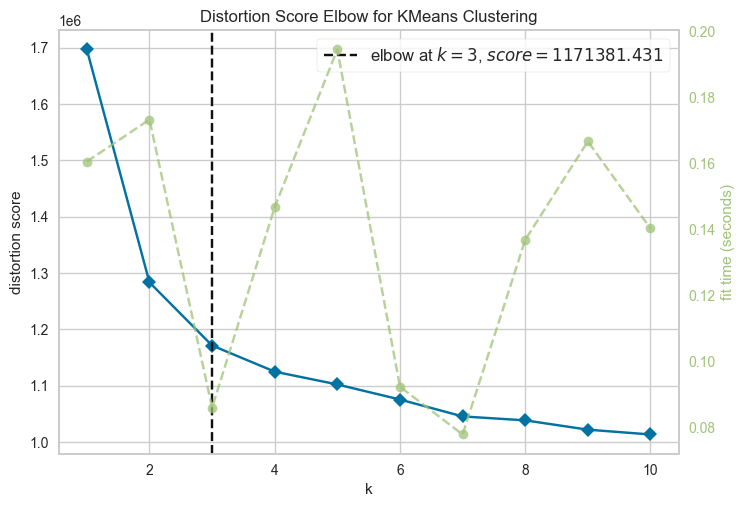

In [14]:
kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(1,11))

visualizer.fit(scaled_df)
_ = visualizer.show()

We can see from the elbow method's results that one may choose 3 or 4 as k.
We also apply the **Silhouette Score method** to compare the results.

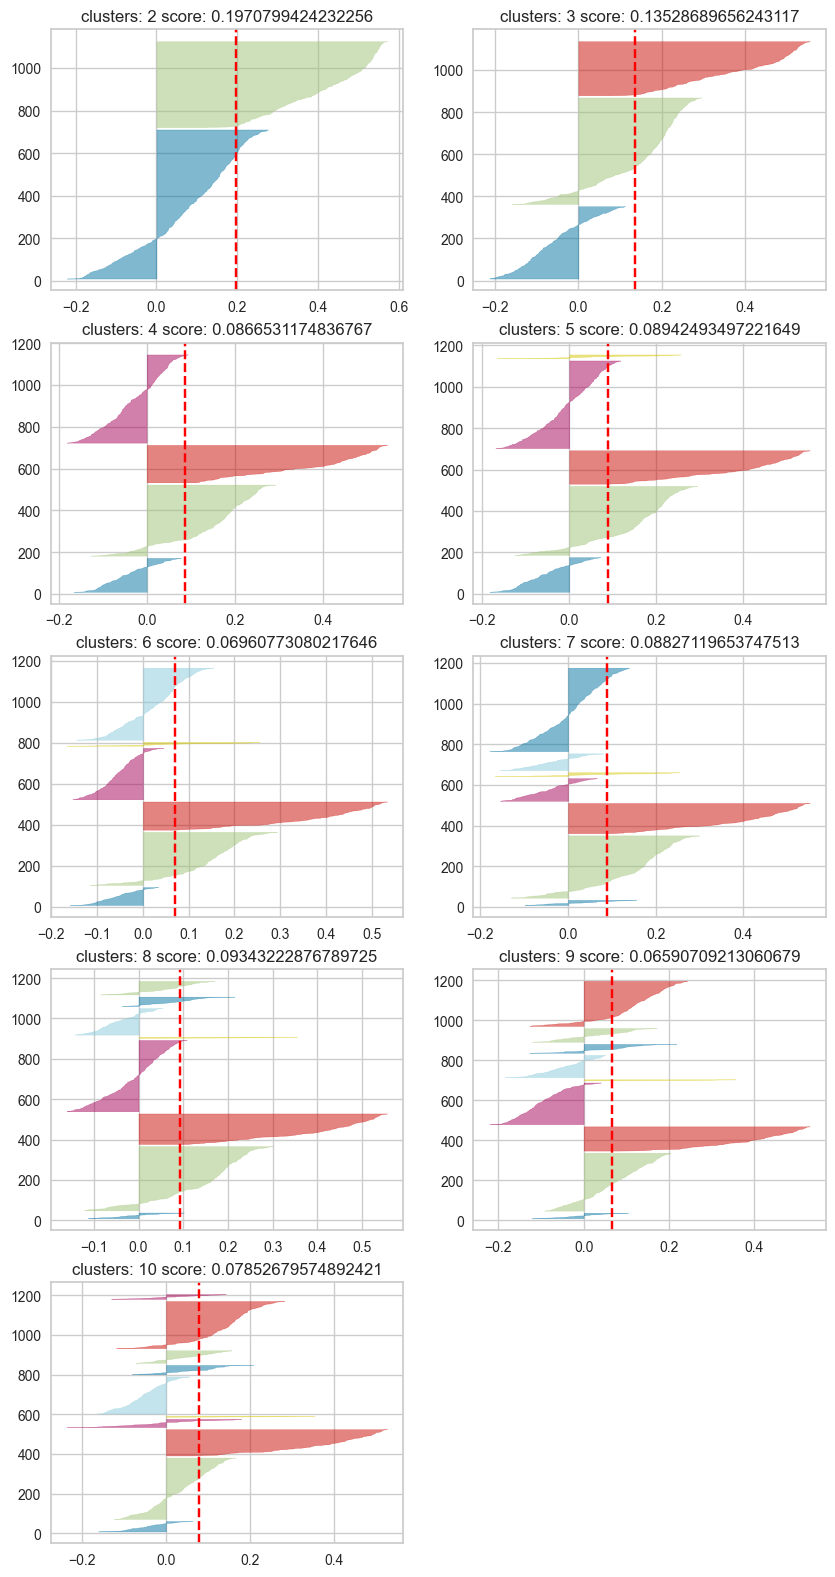

In [15]:
plt.figure(figsize=(2 * 5,  10 * 4))

scores = {}
for n_clusters in range(2, 11):
    plt.subplot(10, 2, n_clusters - 1)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(scaled_df)
    scores[n_clusters] = visualizer.silhouette_score_
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

In [16]:
# Sort the amount of clusters sorted by the overall score
sorted(scores.items(), key=lambda kv: kv[1], reverse=True)

[(2, 0.1970799424232256),
 (3, 0.13528689656243117),
 (8, 0.09343222876789725),
 (5, 0.08942493497221649),
 (7, 0.08827119653747513),
 (4, 0.0866531174836767),
 (10, 0.07852679574892421),
 (6, 0.06960773080217646),
 (9, 0.06590709213060679)]

We can see from the results of the Silhouette Score method that one may choose 2 as k.

We will take the **mean of the observations**, and fit our KMeans model with **number of clusters = 3**.

In [17]:
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(scaled_df)
kmeans

KMeans(n_clusters=3, random_state=0)

We will now map each song to its cluster and add the result as new column in the original dataframe.

In [18]:
# Mapping dictionary
cluster_names = {0: 'intense', 1: 'calm', 2: 'vibrant'}

df['clusteringLabel'] = [cluster_names[cluster] for cluster in clusters]
df.head()

,trackId,artists,songTitle,chordsScale,chordsKey,bpm,rhythmHist,regularity,rhythmPattern,keyKey,loudness,pitchBiHist,keyScale,clusteringLabel
0,3Vo4wInECJQuz9BIBMOu8i,"[Bruno Mars, Cardi B]",Finesse (Remix) [feat. Cardi B],minor,F,104.992523,"[16.8285816268, 13.671369549, 12.3919854605, 1...",1.254250,"[0.044795403000000004, 0.052395507800000005, 0...",F,-9.026863,"[[0.0, 0.1277345147, 0.14194756320000002, 0.10...",minor,intense
1,7ef4DlsgrMEH11cDZd32M6,"[Calvin Harris, Dua Lipa]",One Kiss (with Dua Lipa),minor,A,123.547798,"[21.1346154077, 18.6496586356, 16.3906795752, ...",1.325307,"[0.0177695819, 0.027610449300000003, 0.0229472...",A,-6.811761,"[[0.0, 0.11182582760000001, 0.0811748826, 0.03...",minor,intense
2,3Nou5g8qSke2RT562MoAtn,[Monique Namaste],Water Harp,minor,F,103.211197,"[10.1532813965, 5.9777501213, 6.4212765238, 4....",0.948574,"[0.0185314204, 0.0444592176, 0.034440893800000...",F,-11.597279,"[[0.0, 0.014519404100000001, 0.0005754217, 0.0...",minor,calm
3,5wfHmgTmRjXVdVTn7YVKtx,"[Cameron, Yoga Music, Spa, Massage]",Epic Dream,major,G,116.554108,"[20.8648159848, 14.171234524599999, 10.3256045...",1.012330,"[0.0142917145, 0.0385265817, 0.0566188779, 0.0...",G,-11.627250,"[[0.0, 0.0575464752, 0.016889968800000002, 0.0...",major,calm
4,4oIZXnjmEjq2FWMBl1D8ef,"[Cameron, Yoga Music, Meditation Spa]",Tantric Sleep,major,D,154.680176,"[10.6034373863, 5.3603348431, 4.4752242598, 3....",1.076835,"[0.0137198961, 0.031543038600000003, 0.0306120...",D,-12.274364,"[[0.0, 0.0161060935, 0.0092525277, 0.000938512...",major,calm


In [19]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2], dtype=int32), array([344, 257, 506]))

We can observe that the clusters are well splitted:
* 344 songs where inserted on the **Intense** cluster.
* 257 songs where inserted on the **Calm** cluster.
* 506 songs where inserted on the **Vibrant** cluster.

In [20]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_df)
pca.explained_variance_ratio_

array([0.37211076, 0.03915656])

* The explained variance ratios for the two principal components are **0.3721** and **0.0392**, respectively.
* The first principal component captures approximately **37.2%** of the total variance in the data, indicating it is the most significant contributor to dimensionality reduction.
* The second principal component accounts for **3.9%** of the variance, suggesting diminishing returns in additional dimensions.
* Together, these two components explain **41.1%** of the dataset’s variance, implying that further components may be necessary for more comprehensive representation. While more components might better represent the dataset, these two are adequate for visual exploration.

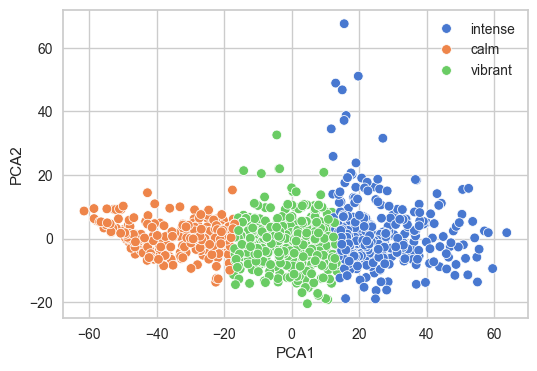

In [21]:
plt.figure(figsize=(6, 4))

mapped_labels = [cluster_names[label] for label in kmeans.labels_]

_ = sns.scatterplot(
  x=pca_data[:, 0], 
  y=pca_data[:, 1], 
  hue=mapped_labels, 
  palette=sns.color_palette('muted', n_colors=3)
  )

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

From the scatterplot, we can observe that the data points are effectively clustered, showing clear separation between different groups. The distribution of points within each cluster appears dense and well-defined, suggesting that the clustering method (e.g., KMeans) has performed well. The PCA transformation helped reduce dimensionality while maintaining significant structure in the data, providing a simplified yet informative view of the underlying patterns. The separation between clusters highlights the distinctiveness of the groups, which can be useful for further analysis or classification tasks.

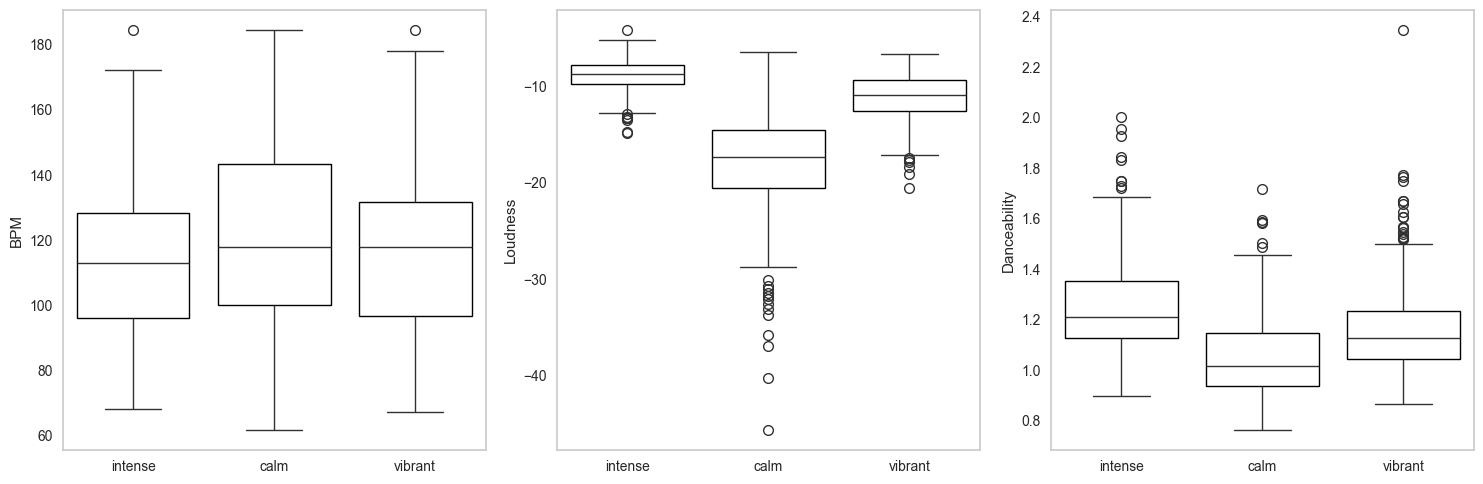

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot a boxplot showing the bpm for each cluster label
sns.boxplot(
  x='clusteringLabel', 
  y='bpm', 
  data=df, 
  ax=axes[0],
  boxprops=dict(facecolor='none', edgecolor='black')
  )

# Plot a boxplot showing the loudness for each cluster label
sns.boxplot(
  x='clusteringLabel', 
  y='loudness', 
  data=df, 
  ax=axes[1],
  boxprops=dict(facecolor='none', edgecolor='black')
  )

# Plot a boxplot showing the danceability for each cluster label
sns.boxplot(
  x='clusteringLabel', 
  y='regularity', 
  data=df, 
  ax=axes[2],
  boxprops=dict(facecolor='none', edgecolor='black')
  )

axes[0].set_ylabel('BPM')
axes[1].set_ylabel('Loudness')
axes[2].set_ylabel('Danceability')

# Remove x-axis labels and grid lines in each subplot
[axe.set_xlabel('') for axe in axes]
[axe.grid(False) for axe in axes]

plt.tight_layout()
plt.show()

The analysis of tempo, loudness, and danceability reveals notable differences across the three music archetypes—calm, vibrant, and intense. 
* For both loudness and danceability, the intense group exhibits the highest values, while the calm group has the lowest. The vibrant group falls in between. 
* In contrast, the tempo, measured in beats per minute, is highest for the calm group, followed by vibrant and intense. This is likely because the calm group, consisting of instrumental genres like classical and meditation music, tends to feature slower, more complex rhythms.

In [23]:
def radar_factory(keys, values, axes=None, color='b', fontsize=10, figsize=(5, 5)):
    
    import math
    
    if axes is None:
        # Initialise the spider plot.
        plt.figure(figsize=figsize)
        ax = plt.subplot(111, polar=True)
    else:
        ax = axes
        
    num_categories = len(keys)
 
    # What will be the angle of each axis in the plot? 
    # We divide the plot / number of variables + 1.
    # We add one because we want to do a complete circle.
    angles = np.arange(num_categories + 1)
    angles = angles / num_categories * 2 * np.pi 
    angles[-1] = angles[0]
 
    # We want the first axis to be on top.
    ax.set_theta_offset(np.pi / 2)
    # Theta direction is -1 clockwise,
    # and 1 counterclockwise
    ax.set_theta_direction(-1)
 
    # Draw one axis per variable and add x labels
    ax.tick_params(labelsize=fontsize)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(keys)
 
    # Draw y labels
    ax.set_rlabel_position(0)

    values.append(values[0])
    ax.plot(list(angles), values, 
            linewidth=1, linestyle='solid', color=color)

    ax.fill(angles, values, alpha=0.2, color=color)
    yticks = ax.get_yticks()
    ax.set_yticklabels([])
    ylims = ax.get_ylim()
    ax.set_ylim(min(yticks[0], ylims[0]), 
                max(yticks[-1], ylims[1]))

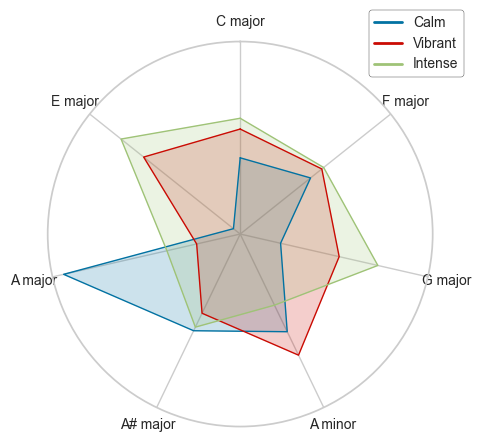

In [24]:
labels = ["C major", "F major", "G major", "A minor", "A# major", "A major", "E major"]
colors = ['b', 'r', 'g']

fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))

# Iterate over each clustering label and plot the radar chart
for label, color in zip(df['clusteringLabel'].unique(), colors):
    cluster_data = scaled_df[df['clusteringLabel'] == label]
    values = [cluster_data['chordsKey_C'].mean(), 
              cluster_data['chordsKey_F'].mean(),
              cluster_data['chordsKey_G'].mean(),
              cluster_data['chordsKey_A'].mean(),
              cluster_data['chordsKey_A#'].mean(),
              cluster_data['chordsKey_E'].mean(),
              cluster_data['keyScale_major'].mean()]
    
    radar_factory(labels, values, axes=ax, color=color)

# Disable circular grid lines
ax.yaxis.grid(False)

custom_legend = [
    Line2D([0], [0], color=colors[0], lw=2, label='Calm'),
    Line2D([0], [0], color=colors[1], lw=2, label='Vibrant'),
    Line2D([0], [0], color=colors[2], lw=2, label='Intense')
]

plt.legend(
    handles=custom_legend, 
    bbox_to_anchor=(1.1, 1.1),
    frameon=True, 
    edgecolor='black'
    )

For the three music archetypes, the top musical keys for each group are as follows:

- **Calm Group:** The most common keys are A Major, A# Major, and A minor.
- **Intense Group:** The leading keys are E Major, G Major, and A# Major.
- **Vibrant Group:** The most frequent keys are A minor, E Major, and F Major.

These key choices reflect the distinct musical preferences and overall mood characteristics within each group.

In [25]:
x = (json_data['clusteringLabel'] == df['clusteringLabel']).sum()
y = len(json_data)

print(f'{x} found with the right label from {y}. Percentage is {x/y}')

593 found with the right label from 1107. Percentage is 0.5356820234869015


This percentage indicates that the clustering performed with KMeans on the dataset has a moderate match with the ground truth labels, but it is far from perfect. The difference between my results and the aticle's clusters may stem from variations in feature selection, scaling methods, or the clustering algorithm used. Their approach may have utilized a more sophisticated method or domain-specific considerations that yielded more accurate clustering results. Therefore, the relatively low percentage suggests that this model could benefit from further refinement and feature adjustments.

### Q2: Classification

Following the classification, the authors build a classifier to predict the class (defined as the cluster) of a song. The authors build their classifier using Random Forests and they use a series of models, described in Table 3. Do the same, for all models, using scikit-learn, XGBoost, LightGBM, and CatBoost. Report your results.

Beyond the tree-based classifiers, proceed to build a neural-network classifier using TensorFlow or PyTorch. Report also your results.

In [26]:
scaled_df['clusteringLabel'] = df['clusteringLabel']
scaled_df

,bpm,regularity,loudness,chordsScale_major,chordsScale_minor,chordsKey_A,chordsKey_A#,chordsKey_B,chordsKey_C,chordsKey_C#,...,rhythmPattern_1434,rhythmPattern_1435,rhythmPattern_1436,rhythmPattern_1437,rhythmPattern_1438,rhythmPattern_1439,rhythmPattern_1440,pitchBiHist_1_mean,pitchBiHist_1_std,clusteringLabel
0,-0.503090,0.521998,0.641781,-1.276501,1.276501,-0.412541,-0.290226,-0.269582,-0.405016,-0.315127,...,1.003070,0.858979,0.758118,0.547144,0.579533,0.328195,0.301101,0.349832,0.046853,intense
1,0.244633,0.911432,1.105036,-1.276501,1.276501,2.424000,-0.290226,-0.269582,-0.405016,-0.315127,...,1.171385,0.893498,0.660117,0.608122,1.027753,1.157132,0.881879,-0.140113,-0.277522,intense
2,-0.574873,-1.153291,0.104218,-1.276501,1.276501,-0.412541,-0.290226,-0.269582,-0.405016,-0.315127,...,-1.094225,-0.940991,-0.952112,-1.001295,-1.077197,-1.165958,-1.118590,-0.526326,-1.311006,calm
3,-0.037192,-0.803868,0.097950,0.783392,-0.783392,-0.412541,-0.290226,-0.269582,-0.405016,-0.315127,...,-0.724392,-0.981954,-0.920507,-0.916472,-1.020182,-1.017758,-1.007227,-0.442758,-1.168849,calm
4,1.499176,-0.450345,-0.037384,0.783392,-0.783392,-0.412541,-0.290226,-0.269582,-0.405016,-0.315127,...,-1.060966,-1.086141,-0.997906,-0.969026,-0.996083,-1.083266,-1.076639,-0.514147,-1.162400,calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,0.227675,-1.103292,-0.203021,-1.276501,1.276501,2.424000,-0.290226,-0.269582,-0.405016,-0.315127,...,-0.956899,-0.883913,-0.763550,-0.574042,-0.583955,-0.467442,-0.616044,-0.195256,-1.078661,vibrant
1103,-0.313884,-0.088072,0.147535,0.783392,-0.783392,-0.412541,-0.290226,-0.269582,2.469039,-0.315127,...,-0.535119,-0.313275,-0.426772,-0.563434,-0.628236,-0.875883,-0.813747,-0.145259,0.209497,vibrant
1104,0.321840,-0.925935,0.156199,0.783392,-0.783392,-0.412541,-0.290226,-0.269582,-0.405016,-0.315127,...,-0.436230,-0.615738,-0.579816,-0.531370,-0.522636,-0.559026,-0.680101,-0.148982,-0.605421,vibrant
1105,-1.350547,-0.273072,0.577714,0.783392,-0.783392,-0.412541,-0.290226,-0.269582,-0.405016,3.173326,...,0.207400,-0.060952,0.190573,0.461675,0.226703,0.112583,0.100485,-0.333450,-0.403040,intense


In [27]:
# Group columns by their prefix
grouped_columns = {
  'chordsScale': [col for col in scaled_df.columns if col.startswith('chordsScale')],
  'chordsKey': [col for col in scaled_df.columns if col.startswith('chordsKey')],
  'keyKey': [col for col in scaled_df.columns if col.startswith('keyKey')],
  'keyScale': [col for col in scaled_df.columns if col.startswith('keyScale')],
  'rhythmPattern': [col for col in scaled_df.columns if col.startswith('rhythmPattern')],
  'rhythmHist': [col for col in scaled_df.columns if col.startswith('rhythmHist')],
  'pitchBiHist': [col for col in scaled_df.columns if col.startswith('pitchBiHist')], 
  'bpm': ['bpm'],
  'regularity': ['regularity'],
  'loudness': ['loudness']
}

In [28]:
categories = {
    'Rhythm Histogram (RH)': (grouped_columns['rhythmHist']),
    'Rhythm Patterns (RP)': (grouped_columns['rhythmPattern']),
    'Stimulative Loudness': (grouped_columns['loudness']),
    'Stimulative Tempo': (grouped_columns['bpm']),
    'Danceability': (
      grouped_columns['bpm'] +
      grouped_columns['regularity'] +
      grouped_columns['rhythmHist'] +
      grouped_columns['rhythmPattern']),
    'Melody': (grouped_columns['pitchBiHist']),
    'Harmony': (
      grouped_columns['chordsScale'] +
      grouped_columns['chordsKey'] +
      grouped_columns['keyKey'] +
      grouped_columns['keyScale']),
    'All except RH and RP': (
      grouped_columns['loudness'] +
      grouped_columns['bpm'] +
      grouped_columns['regularity'] +
      grouped_columns['pitchBiHist'] +
      grouped_columns['chordsScale'] +
      grouped_columns['chordsKey'] +
      grouped_columns['keyKey'] +
      grouped_columns['keyScale']),
    'All': (
      grouped_columns['chordsScale'] +
      grouped_columns['chordsKey'] +
      grouped_columns['keyKey'] +
      grouped_columns['keyScale'] +
      grouped_columns['rhythmPattern'] +
      grouped_columns['rhythmHist'] +
      grouped_columns['pitchBiHist'] +
      grouped_columns['bpm']) +
      grouped_columns['regularity'] +
      grouped_columns['loudness']
}

# method that gets the columns by category
get_columns_by_category = {
  group: scaled_df[columns + ['clusteringLabel']] for group, columns in categories.items()
  }

We group the dataset columns into each category using the following logic: 

1.  `Rhythm Histogram (RH)`: The "rhythm histogram" refers to a representation of the distribution of rhythmic events over time, such as beats or pulses in a musical piece. This feature directly captures the timing and frequency of rhythmic patterns.

2. `Rhythm Patterns (RP)`: Rhythm patterns describe the organization of beats or pulses over time, which is closely tied to the structure of rhythm in a piece of music. The "rhythmPattern" column contains data on rhythmic structures like syncopations, patterns of long and short beats, etc.

3. `Stimulative Loudness`: "Stimulative loudness" refers to the intensity or volume of the sound, which can have a significant impact on how stimulating or energetic a song feels. Loudness is a direct measure of this, so it's the only feature needed for this category.

4. `Stimulative Tempo`: The tempo of a song (measured in beats per minute, or **BPM**) is one of the primary factors in determining how stimulating or energetic a piece of music feels. Faster tempos tend to feel more stimulating, while slower tempos might feel calmer.

5. `Danceability`: Danceability is a measure of how suitable a track is for dancing, which depends on a variety of rhythmic factors:
  - **BPM (beats per minute)**: The tempo, directly influencing how "groovy" or "danceable" a track feels.
  - **Regularity**: Regularity in rhythm (or periodicity) refers to how consistent or predictable the beat is, which also contributes to the ease of dancing. A more regular rhythm is easier to follow.
  - **Rhythm Hist**: The rhythm histogram reflects the structure of rhythms over time, influencing how well a track fits a consistent danceable pattern.
  - **Rhythm Pattern**: Similar to the rhythm histogram, this captures the patterns of rhythm, which is also key in determining whether a piece of music is conducive to dancing. Complex or irregular rhythm patterns can make a piece harder to dance to.

6. `Melody`: Melody is defined by the sequence of notes or pitches over time. The **pitchBiHist** column represents the distribution of pitch, which is central to defining a melody.

7. `Harmony`: Harmony refers to the combination of different musical notes or chords that sound good together:
  - **ChordsScale**: This represents the scale used in the chord progression, influencing the harmonic structure of the music.
  - **ChordsKey**: The key of the song dictates the set of possible harmonies and chords that work within the piece.
  - **KeyKey**: The key of the piece is crucial in determining the overall harmonic context.
  - **KeyScale**: The scale associated with the key, influencing which notes and chords fit together harmoniously.

8. `All except RH and RP`: This category aggregates almost all features except the rhythm-based ones (rhythm histogram and rhythm patterns):
  - **Loudness** and **BPM** contribute to the overall energy of the track (stimulative loudness and tempo).
  - **Regularity**, **PitchBiHist**, **ChordsScale**, **ChordsKey**, **KeyKey**, and **KeyScale** contribute to other musical aspects like harmony, melody, and the overall structure of the song, which would affect the general characteristics of the track.

9. `All`: This category is designed to encompass all the relevant features that capture the full spectrum of a song’s characteristics:
  - **Rhythm features** (e.g., `rhythmPattern`, `rhythmHist`) capture the structure and timing of the music.
  - **Melodic features** (e.g., `pitchBiHist`) capture the melodic aspects of the music.
  - **Harmonic features** (e.g., `chordsScale`, `chordsKey`, `keyKey`, `keyScale`) capture the harmonic richness.
  - **Energetic features** (e.g., `bpm`, `regularity`, `loudness`) contribute to the overall energy and tempo of the music.

In [29]:
# This method trains a dummy classifier with a given dataset and returns the results
def train_dummy_classifier(df):
    X = df.drop('clusteringLabel', axis=1)
    y = df['clusteringLabel']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.3, 
        random_state=42
    )
    
    # Initialize the DummyClassifier with the 'stratified' strategy
    baseline_clf = DummyClassifier(strategy='stratified', random_state=42)
    baseline_clf.fit(X_train, y_train)
    
    y_pred = baseline_clf.predict(X_test)
    
    # Get the classification report
    class_report_dict = classification_report(y_test, y_pred, output_dict=True)

     # Initialize a dictionary to store the metrics
    metrics = {}

    # Add per-class Accuracy, Precision, Recall, F1-Score for each category
    for class_name, metrics_data in class_report_dict.items():
        if class_name not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip non-class metrics
            class_accuracy = (y_pred == y_test)[y_test == class_name].mean()
            metrics[class_name] = {
                'accuracy': class_accuracy,
                'precision': metrics_data.get('precision', None),
                'recall': metrics_data.get('recall', None),
                'f1-score': metrics_data.get('f1-score', None)
            }
    
    return metrics

In [30]:
# This method trains a classifier for each category and returns the results
def produce_results_table(get_columns_by_category, model, train_classifier_func, n_splits=5):
    results = []

    # Iterate over each category and its corresponding DataFrame
    for category, df in get_columns_by_category.items():
        category_metrics = train_classifier_func(df, model, n_splits)

        # Iterate over each class in the metrics
        for class_name, metrics in category_metrics.items():
            if class_name not in ['accuracy', 'macro avg', 'weighted avg']:  # Exclude non-class metrics
                row = {
                    'Category': category,
                    'Class': class_name,
                    'Accuracy': metrics.get('accuracy', None),
                    'Precision': metrics.get('precision', None),
                    'Recall': metrics.get('recall', None),
                    'F1-Score': metrics.get('f1-score', None),
                }
                results.append(row)

    # Now, get the baseline results for each class in this category
    baseline_metrics = train_dummy_classifier(df)

    # Iterate over each class in the baseline metrics
    for class_name, metrics in baseline_metrics.items():
        if class_name not in ['accuracy', 'macro avg', 'weighted avg']:  # Exclude non-class metrics
            row = {
                'Category': 'Baseline',
                'Class': class_name,
                'Accuracy': metrics.get('accuracy', None),
                'Precision': metrics.get('precision', None),
                'Recall': metrics.get('recall', None),
                'F1-Score': metrics.get('f1-score', None),
            }
            results.append(row)

    # Convert the list of rows into a DataFrame and return it
    return pd.DataFrame(results)

In [ ]:
# This method trains a classifier with a given dataset and returns the results
def train_classifier(df, model, n_splits=5):
    X = df.drop('clusteringLabel', axis=1)
    y = df['clusteringLabel']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Wrap the model with OneVsRestClassifier
    clf = OneVsRestClassifier(model)

    skf = StratifiedKFold(n_splits, shuffle=True, random_state=42)

    # List to store accuracy scores
    all_metrics = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train)

        # Predict and get classification report
        y_pred = clf.predict(X_test)
        class_report = classification_report(y_test, y_pred, output_dict=True)

        # Collect fold metrics
        fold_metrics = {'accuracy': accuracy_score(y_test, y_pred)}
        for class_name, metrics in class_report.items():
            if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
                class_accuracy = (y_pred == y_test)[y_test == class_name].mean()
                fold_metrics[class_name] = {
                    'accuracy': class_accuracy,
                    'precision': metrics.get('precision'),
                    'recall': metrics.get('recall'),
                    'f1-score': metrics.get('f1-score')
                }

        all_metrics.append(fold_metrics)

    # Average metrics across folds
    avg_metrics = {}

    for fold_metrics in all_metrics:
        # Average per-class metrics
        for class_name in fold_metrics:
            if class_name not in ['accuracy']:
                if class_name not in avg_metrics:
                    avg_metrics[class_name] = {'accuracy': [], 'precision': [], 'recall': [], 'f1-score': []}

                avg_metrics[class_name]['accuracy'].append(fold_metrics[class_name]['accuracy'])
                avg_metrics[class_name]['precision'].append(fold_metrics[class_name]['precision'])
                avg_metrics[class_name]['recall'].append(fold_metrics[class_name]['recall'])
                avg_metrics[class_name]['f1-score'].append(fold_metrics[class_name]['f1-score'])

    # Calculate the averages
    for class_name, metrics in avg_metrics.items():
        avg_metrics[class_name]['accuracy'] = np.mean(metrics['accuracy'])
        avg_metrics[class_name]['precision'] = np.mean(metrics['precision'])
        avg_metrics[class_name]['recall'] = np.mean(metrics['recall'])
        avg_metrics[class_name]['f1-score'] = np.mean(metrics['f1-score'])

    return avg_metrics

We will use **Grid Search** to find the optimal hyperparamteres for our Random Forest Classifier.

In [ ]:
# Define our model
rf = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Split the data into training sets
X_train, y_train = get_columns_by_category['All'].drop('clusteringLabel', axis=1), get_columns_by_category['All']['clusteringLabel']

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to training data
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Best Cross-validation Score: 0.9268558150911093


After getting the optimal hyperparameters we will use them to fit our model.

In [ ]:
rf_model = RandomForestClassifier(
  criterion='entropy',
  max_depth=10, 
  min_samples_split=10,
  n_estimators=50,
  random_state=42, 
  verbose=0)

results_table = produce_results_table(get_columns_by_category, rf_model, train_classifier)
results_table

,Category,Class,Accuracy,Precision,Recall,F1-Score
0,Rhythm Histogram (RH),calm,0.945777,0.950635,0.945777,0.946894
1,Rhythm Histogram (RH),intense,0.878005,0.938412,0.878005,0.907000
2,Rhythm Histogram (RH),vibrant,0.934770,0.894660,0.934770,0.914073
3,Rhythm Patterns (RP),calm,0.937934,0.963983,0.937934,0.950151
4,Rhythm Patterns (RP),intense,0.892540,0.946663,0.892540,0.918006
5,Rhythm Patterns (RP),vibrant,0.946651,0.900641,0.946651,0.922927
6,Stimulative Loudness,calm,0.700226,0.829123,0.700226,0.756995
7,Stimulative Loudness,intense,0.607673,0.629472,0.607673,0.615291
8,Stimulative Loudness,vibrant,0.691788,0.631568,0.691788,0.657967
9,Stimulative Tempo,calm,0.159427,0.309608,0.159427,0.208853


1. **Best Performing Categories:**
   - **Rhythm Histogram (RH)**, **Rhythm Patterns (RP)**, and **Danceability** show high accuracy (90%+) across all classes (calm, intense, vibrant), with excellent F1-scores.
   - **All** category also performs well, with accuracy around 94% for calm and vibrant, and 90% for intense.

2. **Challenging Categories:**
   - **Melody** and **Harmony** perform poorly, especially for the "intense" class, with Melody's accuracy as low as 33.7%.
   - **Stimulative Loudness** and **Stimulative Tempo** categories have low accuracy, especially for calm and intense classes (e.g., 16% for calm in **Stimulative Tempo**).

3. **Baseline Comparison:**
   - **Baseline** results are significantly worse, showing that the model is outperforming the baseline in all cases.

4. **Overall Trends:**
   - The model excels in rhythm and danceability features, but struggles with tempo and loudness features.
   - The model is efficient, running in just 22 seconds despite having a large number of features.

The results we obtained differ significantly from those in the article, but a key factor that may explain this discrepancy is how we handled our categories. The columns I used for training each model in each category are subjective, and there could be different opinions on which features should be included. This variation in feature selection can lead to different outcomes, highlighting that the approach to categorizing and choosing features plays a critical role in the model’s performance.

In [1145]:
# Define the model
xgb = XGBClassifier(eval_metric='mlogloss')

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.1, 0.2]
}

X_train, y_train = get_columns_by_category['All'].drop('clusteringLabel', axis=1), get_columns_by_category['All']['clusteringLabel']

# Encode the target labels into numerical values for XGBClassifier
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

Best Hyperparameters: {'gamma': 0, 'max_depth': 5, 'n_estimators': 200}
Best Cross-validation Score: 0.925033630915984


In [1146]:
xgb_model = XGBClassifier(
  eval_metric='mlogloss',
  gamma=0,
  max_depth=5,
  n_estimators=200,
  )

results_table = produce_results_table(get_columns_by_category, xgb_model, train_classifier)
results_table

,Category,Class,Accuracy,Precision,Recall,F1-Score
0,Rhythm Histogram (RH),calm,0.933786,0.948399,0.933786,0.940764
1,Rhythm Histogram (RH),intense,0.909889,0.941464,0.909889,0.924984
2,Rhythm Histogram (RH),vibrant,0.934770,0.907745,0.934770,0.920907
3,Rhythm Patterns (RP),calm,0.930090,0.956318,0.930090,0.942262
4,Rhythm Patterns (RP),intense,0.895482,0.943789,0.895482,0.918050
5,Rhythm Patterns (RP),vibrant,0.940730,0.898713,0.940730,0.919043
6,Stimulative Loudness,calm,0.719306,0.798099,0.719306,0.753412
7,Stimulative Loudness,intense,0.616240,0.635673,0.616240,0.624366
8,Stimulative Loudness,vibrant,0.679868,0.637845,0.679868,0.657217
9,Stimulative Tempo,calm,0.319080,0.357318,0.319080,0.336814


In [1157]:
lgbm_model = LGBMClassifier(metric='auc')

results_table = produce_results_table(get_columns_by_category, lgbm_model, train_classifier)
results_table

,Category,Class,Accuracy,Precision,Recall,F1-Score
0,Rhythm Histogram (RH),calm,0.937858,0.941627,0.937858,0.939001
1,Rhythm Histogram (RH),intense,0.915729,0.930006,0.915729,0.922674
2,Rhythm Histogram (RH),vibrant,0.922947,0.912448,0.922947,0.917532
3,Rhythm Patterns (RP),calm,0.941704,0.945137,0.941704,0.943189
4,Rhythm Patterns (RP),intense,0.895439,0.967115,0.895439,0.929119
5,Rhythm Patterns (RP),vibrant,0.950592,0.904526,0.950592,0.926834
6,Stimulative Loudness,calm,0.719683,0.774190,0.719683,0.744132
7,Stimulative Loudness,intense,0.578602,0.596479,0.578602,0.585207
8,Stimulative Loudness,vibrant,0.636478,0.605060,0.636478,0.618838
9,Stimulative Tempo,calm,0.210332,0.342016,0.210332,0.256343


In [ ]:
cat_boost_model = CatBoostClassifier(random_state=42, verbose = 0)
results_table = produce_results_table(get_columns_by_category, cat_boost_model, train_classifier)
results_table

,Category,Class,Accuracy,Precision,Recall,F1-Score
0,Rhythm Histogram (RH),calm,0.922172,0.955782,0.922172,0.938059
1,Rhythm Histogram (RH),intense,0.898252,0.948471,0.898252,0.922499
2,Rhythm Histogram (RH),vibrant,0.944652,0.897072,0.944652,0.920107
3,Rhythm Patterns (RP),calm,0.961161,0.976610,0.961161,0.968617
4,Rhythm Patterns (RP),intense,0.912788,0.970181,0.912788,0.940064
5,Rhythm Patterns (RP),vibrant,0.968375,0.924627,0.968375,0.945867
6,Stimulative Loudness,calm,0.680468,0.863138,0.680468,0.759538
7,Stimulative Loudness,intense,0.593052,0.613602,0.593052,0.600969
8,Stimulative Loudness,vibrant,0.691749,0.613767,0.691749,0.649254
9,Stimulative Tempo,calm,0.101207,0.368158,0.101207,0.154611


In [ ]:
# Load the dataset (assuming it's a DataFrame named 'df')
X = scaled_df.drop(columns=['clusteringLabel'])
y = scaled_df['clusteringLabel']

# Encode categorical labels (if needed)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_dim=X_train.shape[1]),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(
  optimizer='sgd', 
  loss='sparse_categorical_crossentropy', 
  metrics=['accuracy']
  )

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
 1/28 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.2812 - loss: 1.1691

/Users/michaeltheophanopoulos/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5816 - loss: 0.8138 - val_accuracy: 0.7883 - val_loss: 0.4847
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8758 - loss: 0.4158 - val_accuracy: 0.8739 - val_loss: 0.3685
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9243 - loss: 0.3000 - val_accuracy: 0.9144 - val_loss: 0.3106
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9519 - loss: 0.2366 - val_accuracy: 0.9234 - val_loss: 0.2749
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9718 - loss: 0.1881 - val_accuracy: 0.9279 - val_loss: 0.2529
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9626 - loss: 0.1630 - val_accuracy: 0.9324 - val_loss: 0.2364
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9765 - loss: 0.1425 - val_accuracy: 0.9279 - val_loss: 0.2258
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9837 - loss: 0.1159 - val_accuracy: 0.9279 - val_loss: 0.2177
Epo

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

## Submission Instructions

You will submit a Jupyter notebook that will contain all your code, data, and analysis. Ensure that the notebook will run correctly in a computer that is not your own. That means, among other things, that it does not contain absolute paths. Remember that a notebook is not a collection of code cells thrown together; it should contain as much text as necessary for a person to understand what you are doing.

## Honor Code

You understand that this is an individual assignment, and as such you must carry it out alone. You may seek help on the Internet, on ChatGPT/Gemini/etc., by Googling or searching in StackOverflow for general questions pertaining to the use of Python and pandas libraries and idioms. However, it is not right to ask direct questions that relate to the assignment and where people will actually solve your problem by answering them. You may discuss with your colleagues in order to better understand the questions, if they are not clear enough, but you should not ask them to share their answers with you, or to help you by giving specific advice.